#### import the things

In [1]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

idx = pd.IndexSlice

import scipy.stats
import data
raw_data_fol = os.path.join(data.__path__[0], "raw")

In [2]:
from src.data import data_sorting_tools as dst
%load_ext autoreload
%autoreload 2

#### explore keys

In [3]:
tf = os.path.join(raw_data_fol, "lifelong_statuses.json")
with open(tf, 'r') as f:
    ll_tweets = json.load(f)

In [7]:
ll_tweets['0'].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'lang'])

In [70]:
ll_tweets['0']['entities']

{'hashtags': [],
 'symbols': [],
 'user_mentions': [],
 'urls': [{'url': 'https://t.co/2a92fmtNSn',
   'expanded_url': 'https://twitter.com/i/web/status/1334917683372912640',
   'display_url': 'twitter.com/i/web/status/1…',
   'indices': [117, 140]}]}

pulling directly from a timeline doesn't seem to supply the reply_count and quote_count keys for some reason

In [28]:
#keep these top level keys
keepers = ['retweet_count', 'favorite_count', 'created_at']

#check to see what they look like in a dataframe
df, main_dict = dst.json_to_df(tf, keepers, return_dict=True)
df.head()

,retweet_count,favorite_count,created_at
1334917683372912640,0,1,Fri Dec 04 17:49:11 +0000 2020
1204495248187019264,1,3,Tue Dec 10 20:17:00 +0000 2019
1179432824505393152,2,1,Wed Oct 02 16:27:52 +0000 2019
1080491425458925568,0,2,Wed Jan 02 15:50:05 +0000 2019
1079778433813467136,0,2,Mon Dec 31 16:36:54 +0000 2018


#### clean up the dataframe

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 1334917683372912640 to 593899000291549184
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   retweet_count   499 non-null    object
 1   favorite_count  499 non-null    object
 2   created_at      499 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [32]:
df = df.convert_dtypes()
df['created_at'] = pd.to_datetime(df['created_at'])

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 1334917683372912640 to 593899000291549184
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   retweet_count   499 non-null    Int64              
 1   favorite_count  499 non-null    Int64              
 2   created_at      499 non-null    datetime64[ns, UTC]
dtypes: Int64(2), datetime64[ns, UTC](1)
memory usage: 16.6 KB


In [34]:
df.describe()

,retweet_count,favorite_count
count,499.000000,499.000000
mean,0.394790,1.262525
std,0.844575,1.612333
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,2.000000
max,7.000000,12.000000


#### add media column

In [98]:
ll_tweets['7']['extended_entities']['media']

[{'id': 1078720223224700929,
  'id_str': '1078720223224700929',
  'indices': [103, 126],
  'media_url': 'http://pbs.twimg.com/media/DvhiU-VWoAESfxo.jpg',
  'media_url_https': 'https://pbs.twimg.com/media/DvhiU-VWoAESfxo.jpg',
  'url': 'https://t.co/EbmILG9uDP',
  'display_url': 'pic.twitter.com/EbmILG9uDP',
  'expanded_url': 'https://twitter.com/LifelongWA/status/1078720227897073664/photo/1',
  'type': 'photo',
  'sizes': {'medium': {'w': 960, 'h': 640, 'resize': 'fit'},
   'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
   'large': {'w': 960, 'h': 640, 'resize': 'fit'},
   'small': {'w': 680, 'h': 453, 'resize': 'fit'}}},
 {'id': 1078720223228948480,
  'id_str': '1078720223228948480',
  'indices': [103, 126],
  'media_url': 'http://pbs.twimg.com/media/DvhiU-WXcAAuw6c.jpg',
  'media_url_https': 'https://pbs.twimg.com/media/DvhiU-WXcAAuw6c.jpg',
  'url': 'https://t.co/EbmILG9uDP',
  'display_url': 'pic.twitter.com/EbmILG9uDP',
  'expanded_url': 'https://twitter.com/LifelongWA/status/10

In [39]:
media_dict = {}
for key in ll_tweets.keys():
    temp = {}
    if "extended_entities" in ll_tweets[key].keys():
        dk = ll_tweets[key]['id']
        temp['media_count'] = len(ll_tweets[key]['extended_entities']['media'])
        temp['media_types'] = [t['type'] for t in ll_tweets[key]['extended_entities']['media']]
        media_dict[dk] = temp

In [43]:
media_statuses = pd.DataFrame(media_dict).T
media_statuses.head()

,media_count,media_types
1078720227897073664,2,"[photo, photo]"
1069984969089581056,1,[photo]
1068655115635056640,4,"[photo, photo, photo, photo]"
1060570529474654208,1,[photo]
1060208199310073856,1,[photo]


In [48]:
ll_df = pd.concat([df, media_statuses], axis=1).sort_values('created_at', ascending=False)
ll_df.head(15)

,retweet_count,favorite_count,created_at,media_count,media_types
1334917683372912640,0,1,2020-12-04 17:49:11+00:00,NaN,NaN
1204495248187019264,1,3,2019-12-10 20:17:00+00:00,NaN,NaN
1179432824505393152,2,1,2019-10-02 16:27:52+00:00,NaN,NaN
1080491425458925568,0,2,2019-01-02 15:50:05+00:00,NaN,NaN
1079778433813467136,0,2,2018-12-31 16:36:54+00:00,NaN,NaN
1079059702368161797,0,0,2018-12-29 17:00:55+00:00,NaN,NaN
1078772688196390912,0,0,2018-12-28 22:00:26+00:00,NaN,NaN
1078720227897073664,1,1,2018-12-28 18:31:58+00:00,2,"[photo, photo]"
1078019364123602945,0,0,2018-12-26 20:06:59+00:00,NaN,NaN
1077587002919284737,0,2,2018-12-25 15:28:56+00:00,NaN,NaN


In [53]:
ll_df['media_count'] = ll_df['media_count'].fillna(0)
ll_df['media_types'] = ll_df['media_types'].fillna('none')

In [73]:
ll_df.head()

,retweet_count,favorite_count,created_at,media_count,media_types
1334917683372912640,0,1,2020-12-04 17:49:11+00:00,0,none
1204495248187019264,1,3,2019-12-10 20:17:00+00:00,0,none
1179432824505393152,2,1,2019-10-02 16:27:52+00:00,0,none
1080491425458925568,0,2,2019-01-02 15:50:05+00:00,0,none
1079778433813467136,0,2,2018-12-31 16:36:54+00:00,0,none


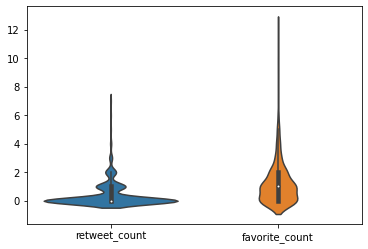

In [67]:
sns.violinplot(data=ll_df[['retweet_count', 'favorite_count']],)
plt.show()

#### add tweet text to the same df, so the data is all stored in one place

In [85]:
keepers = ['text']

text_df = dst.json_to_df(tf, keepers, return_dict=False)
text_df.head()

,text
1334917683372912640,"In order to achieve health for all, we need to..."
1204495248187019264,"65,000 people in WA are living with hepatitis ..."
1179432824505393152,Chronic Disease Management Undermined by Surpr...
1080491425458925568,What are your New Year's resolutions? If you a...
1079778433813467136,"In 2019, we will serve 20,000 more meals than ..."


In [92]:
text_df = text_df.convert_dtypes()

In [94]:
ll_df = pd.concat([ll_df, text_df], axis=1)

In [95]:
ll_df.head()

,retweet_count,favorite_count,created_at,media_count,media_types,text
1334917683372912640,0,1,2020-12-04 17:49:11+00:00,0,none,"In order to achieve health for all, we need to..."
1204495248187019264,1,3,2019-12-10 20:17:00+00:00,0,none,"65,000 people in WA are living with hepatitis ..."
1179432824505393152,2,1,2019-10-02 16:27:52+00:00,0,none,Chronic Disease Management Undermined by Surpr...
1080491425458925568,0,2,2019-01-02 15:50:05+00:00,0,none,What are your New Year's resolutions? If you a...
1079778433813467136,0,2,2018-12-31 16:36:54+00:00,0,none,"In 2019, we will serve 20,000 more meals than ..."


In [96]:
ll_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 1334917683372912640 to 593899000291549184
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   retweet_count   499 non-null    Int64              
 1   favorite_count  499 non-null    Int64              
 2   created_at      499 non-null    datetime64[ns, UTC]
 3   media_count     499 non-null    int64              
 4   media_types     499 non-null    object             
 5   text            499 non-null    string             
dtypes: Int64(2), datetime64[ns, UTC](1), int64(1), object(1), string(1)
memory usage: 28.3+ KB


The media_types column is still an object, and it's a bit messy as it's a combination of strings and lists, but it's more convenient to keep it this way, as it will only be accessed by filtering on the media_count column, anyway.

In [97]:
#save the dataframe as a pickle file to be loaded into other notebooks
pd.to_pickle(ll_df, os.path.join(data.__path__[0], "compiled", "ll_tweets.pkl"))